# Inference: Covariance Adaptive Slice Sampling - Covariance Adaptive
This example shows you how to perform Bayesian inference on a Gaussian distribution and a time-series problem, using
Covariance Adaptive Slice Sampling with Covariance Matching.

First, we create a simple normal distribution.

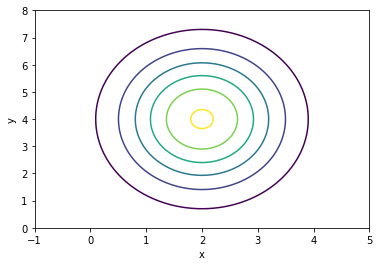

In [2]:
import os
os.chdir("../")
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.GaussianLogPDF([2, 4], [[1, 0], [0, 3]])

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-1, 5, num_points)
y = np.linspace(-0, 8, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [3]:
# Choose starting point for 3 mcmc chains
xs = [
    [2, 4],
    [3, 3],
    [5, 4],
]

# Create mcmc routine
mcmc = pints.MCMCController(log_pdf, 3, xs, method=pints.SliceCovarianceMatchingMCMC)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1000)

for sampler in mcmc.samplers():
    sampler.set_sigma_c(5)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Covariance Adaptive: Covariance Matching
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     26      0:00.0
2     47      0:00.0
3     60      0:00.0
1000  17001   0:05.5
2000  34305   0:11.0
3000  51179   0:16.3
4000  68363   0:21.8
5000  85477   0:27.1
6000  102449   0:32.4
7000  119333   0:37.7
8000  136463   0:43.1
9000  153701   0:48.5
10000 171026   0:53.9
Halting: Maximum number of iterations (10000) reached.
Done!


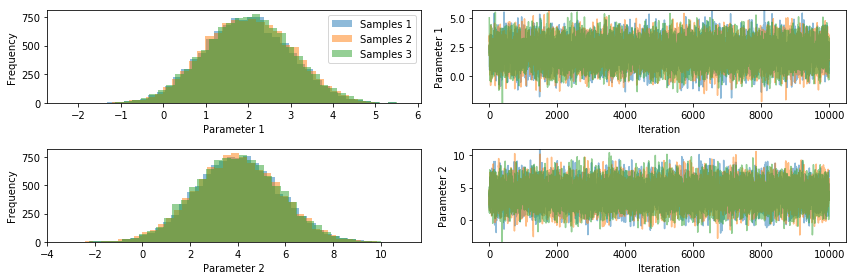

In [4]:
# Show traces and histograms
import pints.plot
pints.plot.trace(full_chains)
plt.show()

R-hat:
[1.000220625370679, 0.9999718702095163]
0.0013579082401027343
0.0013099280255990386
0.001887393229928147


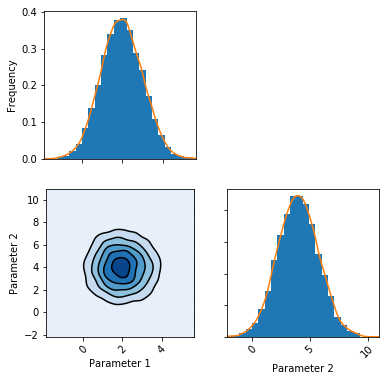

In [5]:
# Discard warm up
chains = full_chains[:, 200:]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Check Kullback-Leibler divergence of chains
print(log_pdf.kl_divergence(chains[0]))
print(log_pdf.kl_divergence(chains[1]))
print(log_pdf.kl_divergence(chains[2]))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)
plt.show()

# Slice Sampling with Covariance Adaptive: Covariance Matching on a time-series problem
We now try the same method on a time-series problem

In [25]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise * 0.1],
    [0.02, 600, noise * 100],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
num_chains = 3
xs = [
    real_parameters * 1.01,
    real_parameters * 0.99,
    real_parameters * 1.01,
]

# Create mcmc routine
mcmc = pints.MCMCController(
    log_posterior, num_chains, xs, method=pints.SliceCovarianceMatchingMCMC)

for sampler in mcmc.samplers():
    sampler.set_sigma_c(0.001)
    
# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1000)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Covariance Adaptive: Covariance Matching
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     16      0:00.0
2     23      0:00.0
3     32      0:00.0


/Users/lorcandelaney/Desktop/pints/pints/_mcmc/_slice_covariance_matching.py:234: RuntimeWarning: divide by zero encountered in double_scalars
  0, sigma_squared ** (-1) - ((


1000  20923   0:11.9
2000  41999   0:23.5
3000  62929   0:35.0
4000  83839   0:46.4
5000  104029   0:57.4
6000  125637   1:09.2
7000  146781   1:20.9
8000  167661   1:32.4
9000  188767   1:43.9
10000 209678   1:55.8
Halting: Maximum number of iterations (10000) reached.
Done!


R-hat:
[4.62591635550521, 204.11391908944714, 3.2491463526718496]


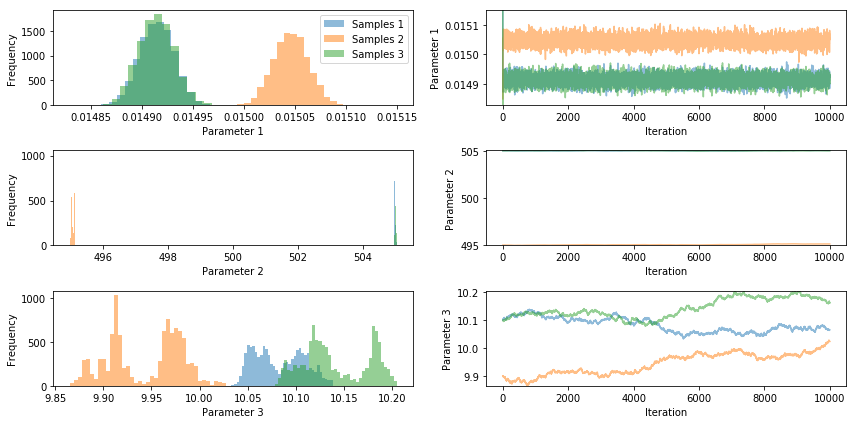

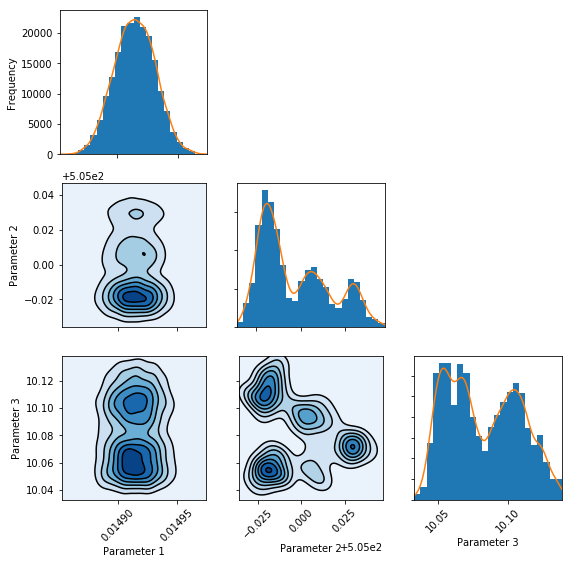

In [26]:
# Show traces and histograms
pints.plot.trace(full_chains)

# Discard warm up
full_chains = full_chains[:, 200:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(full_chains))

# Look at distribution in chain 0
pints.plot.pairwise(full_chains[0], kde=True)

# Show graphs
plt.show()